## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# *****************************************************
## Import And Preprocess Data Set

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Co2/GlobalTemp.csv",skiprows=4)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[:4] + '-' + df['Date'].astype(str).str[4:], format='%Y-%m')
# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,Date,Anomaly
0,1850-01-01,-0.46
1,1850-02-01,-0.22


In [ ]:
df.tail()

,Date,Anomaly
2088,2024-01-01,1.30
2089,2024-02-01,1.42
2090,2024-03-01,1.37
2091,2024-04-01,1.30
2092,2024-05-01,1.18


In [ ]:
df=df.loc[df['Date']>='2000-01-01']

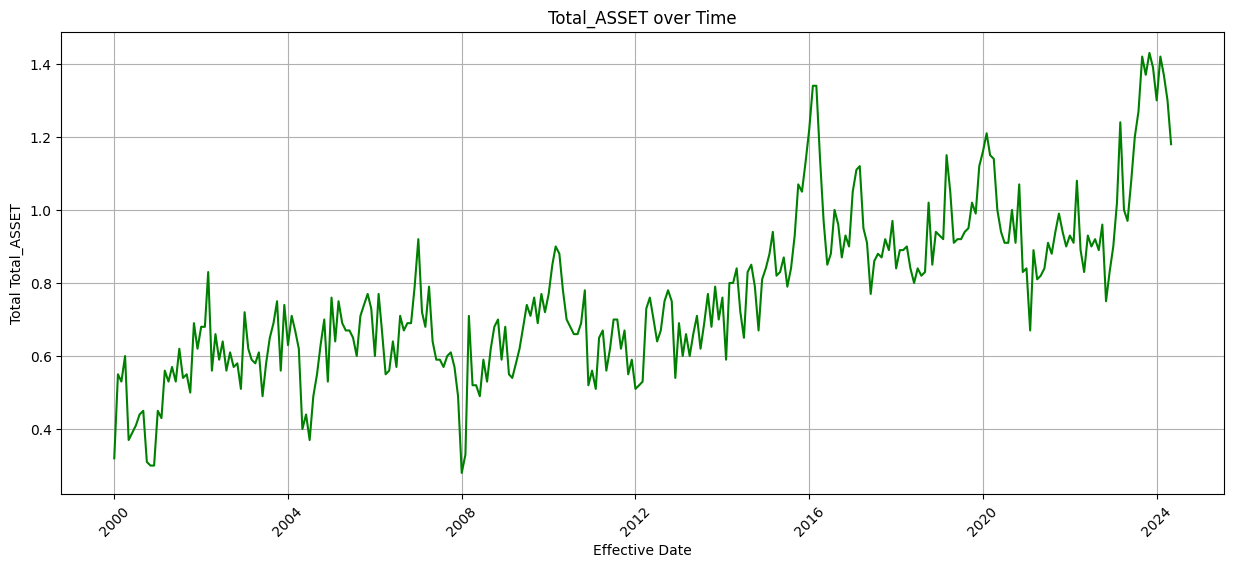

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Anomaly'],  linestyle='-',color='green')
plt.xlabel('Effective Date')
plt.ylabel('Total Total_ASSET')
plt.title('Total_ASSET over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
DF_Test=df.tail(7)

df=df.loc[df['Date']<='2024-05-21']

In [ ]:
df.set_index('Date', inplace=True)

df.head()

,Anomaly
Date,
2000-01-01,0.32
2000-02-01,0.55
2000-03-01,0.53
2000-04-01,0.60
2000-05-01,0.37


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1254 entries, 2019-05-30 to 2024-05-30
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DCOILWTICO          1254 non-null   float64
 1   YEAR                1254 non-null   int64  
 2   MONTH               1254 non-null   int64  
 3   DAY                 1254 non-null   int64  
 4   WEEK_OF_MONTH       1254 non-null   int64  
 5   DAY_OF_WEEK         1254 non-null   int64  
 6   DAY_NAME            1254 non-null   object 
 7   DCOILWTICO_lag_1    1253 non-null   float64
 8   DCOILWTICO_lag_2    1252 non-null   float64
 9   DCOILWTICO_lag_3    1251 non-null   float64
 10  DCOILWTICO_lag_4    1250 non-null   float64
 11  DCOILWTICO_lag_5    1249 non-null   float64
 12  DCOILWTICO_lag_6    1248 non-null   float64
 13  DCOILWTICO_lag_7    1247 non-null   float64
 14  DCOILWTICO_mean_5   1250 non-null   float64
 15  DCOILWTICO_mean_10  1245 non-null   f

In [ ]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Anomaly']])
validate_data = scaler.transform(valid[['Anomaly']])
test_data = scaler.transform(test[['Anomaly']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))


Train data size: 190
Validation data size: 60
Test data size: 43


In [ ]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(5, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1728 - val_loss: 0.3302
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0727 - val_loss: 0.0997
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0245 - val_loss: 0.0244
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0289 - val_loss: 0.0249
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0218 - val_loss: 0.0451
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202 - val_loss: 0.0623
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0198 - val_loss: 0.0510
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0184 - val_loss: 0.0383
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0180 - val_loss: 0.0340
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0186 - val_loss: 0.0403
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - val_loss: 0.0449
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - val_loss: 0.0

In [ ]:
model.save('cnn.h5')

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_val)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_val, test_predict)

# Calculate RMSE for training and test sets
train_rmse = sqrt(train_mse)
test_rmse = sqrt(test_mse)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Train MSE: 0.01429118457178579
Test MSE: 0.014583829237642487
Train RMSE: 0.1195457425916364
Test RMSE: 0.12076352610636411


2/2 [==============================] - 0s 5ms/step


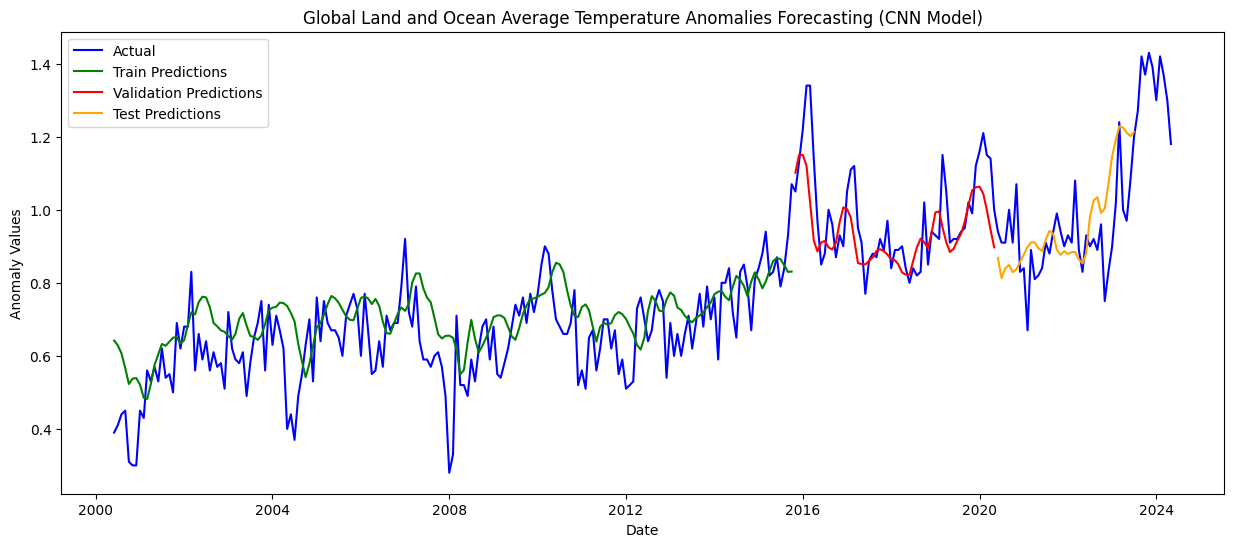

In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
val_predictions = scaler.inverse_transform(val_predictions)


plt.figure(figsize=(15, 6))

plt.plot(df.index[seq_length:], df['Anomaly'][seq_length:], label='Actual', color='blue')

plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')


val_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

test_pred_index = range(seq_length+len(train_predictions)+len(val_predictions), seq_length+len(train_predictions)+len(val_predictions)+len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

plt.title('Global Land and Ocean Average Temperature Anomalies Forecasting (CNN Model)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values')
plt.legend(loc='upper left')
plt.show()